In [0]:
!pip install tqdm

In [0]:
# !pwd

In [0]:
!pip install nbeats-keras
!pip install nbeats-pytorch

In [0]:
# this mounts your Google Drive to the Colab VM.
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

# enter the foldername in your Drive where you have saved the unzipped
# assignment folder, e.g. 'cs231n/assignments/assignment3/'
FOLDERNAME = 'cs230/'
assert FOLDERNAME is not None, "[!] Enter the foldername."

# now that we've mounted your Drive, this ensures that
# the Python interpreter of the Colab VM can load
# python files from within it.
import sys
sys.path.append('/content/drive/My Drive/{}'.format(FOLDERNAME))

# this downloads the CIFAR-10 dataset to your Drive
# if it doesn't already exist.
%cd drive/My\ Drive/$FOLDERNAME/
# !bash get_datasets.sh
# %cd /content

Mounted at /content/drive
/content/drive/My Drive/cs230


In [0]:
# !pip install m5-helpers.py

In [0]:
# !ls

In [0]:
import os, datetime, importlib

# os.environ['KMP_DUPLICATE_LIB_OK']='True'

from typing import Union
import sklearn
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import timedelta
from tqdm import tqdm
tqdm.pandas()

import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, Conv1D, Dense, Activation, Dropout, Lambda, Multiply, Add, Concatenate
from tensorflow.keras.optimizers import Adam

timestring = lambda : datetime.datetime.now().strftime("%H_%M_%S")



In [0]:
# ! cp "/content/drive/My Drive/cs230/m5_helpers.py"
# ! cp "/content/drive/My Drive/cs230/m5_models.py"
% load "/content/drive/My Drive/cs230/m5_helpers.py"
% load "/content/drive/My Drive/cs230/m5_models.py"
# !python -m m5_helpers
# !python -m m5_models

import m5_helpers
import m5_models



In [0]:
!pip install nbeats-keras
!pip install nbeats-pytorch
# import N

In [0]:
path = "/content/drive/My Drive/cs230/data"

# load the three datasets
train_df = pd.read_csv(f'{path}/sales_train_validation.csv')
calendar = pd.read_csv(f'{path}/calendar.csv')
prices = pd.read_csv(f'{path}/sell_prices.csv')

# create train and validation folds
train_fold_df = train_df.iloc[:, :-28]
valid_fold_df = train_df.iloc[:, -28:]

# build our evaluator
e = m5_helpers.WRMSSEEvaluator(train_fold_df, valid_fold_df, calendar, prices)

100%|██████████| 42840/42840 [00:08<00:00, 5339.98it/s]


In [0]:
!pip install nbeats_forecast

In [0]:
from nbeats_forecast import NBeats
import nbeats_forecast as nbeats

In [0]:
# Use this is you want to fit on the full 42840 sequences
df_train = e.train_series
df_valid = e.valid_series
df = pd.concat([df_train, df_valid], axis=1)
df = df.reset_index().rename(columns={'index':'id'})

In [0]:

length = len(df.columns)-1
start_day = datetime.datetime.strptime('2011-01-29', '%Y-%m-%d')
date_list = [(start_day + datetime.timedelta(days=x)).date() for x in range(length)]
df.columns = [df.columns[0]]+date_list
data_start_date = df.columns[1]
data_end_date = df.columns[-1]

date_to_index = pd.Series(index=pd.Index([pd.to_datetime(c) for c in df.columns[1:]]), data=[i for i in range(len(df.columns[1:]))])

# visualize a snippet of our data
print('Data ranges from %s to %s' % (data_start_date, data_end_date))
df.head()

Data ranges from 2011-01-29 to 2016-04-24


,id,2011-01-29,2011-01-30,2011-01-31,2011-02-01,2011-02-02,2011-02-03,2011-02-04,2011-02-05,2011-02-06,2011-02-07,2011-02-08,2011-02-09,2011-02-10,2011-02-11,2011-02-12,2011-02-13,2011-02-14,2011-02-15,2011-02-16,2011-02-17,2011-02-18,2011-02-19,2011-02-20,2011-02-21,2011-02-22,2011-02-23,2011-02-24,2011-02-25,2011-02-26,2011-02-27,2011-02-28,2011-03-01,2011-03-02,2011-03-03,2011-03-04,2011-03-05,2011-03-06,2011-03-07,2011-03-08,...,2016-03-16,2016-03-17,2016-03-18,2016-03-19,2016-03-20,2016-03-21,2016-03-22,2016-03-23,2016-03-24,2016-03-25,2016-03-26,2016-03-27,2016-03-28,2016-03-29,2016-03-30,2016-03-31,2016-04-01,2016-04-02,2016-04-03,2016-04-04,2016-04-05,2016-04-06,2016-04-07,2016-04-08,2016-04-09,2016-04-10,2016-04-11,2016-04-12,2016-04-13,2016-04-14,2016-04-15,2016-04-16,2016-04-17,2016-04-18,2016-04-19,2016-04-20,2016-04-21,2016-04-22,2016-04-23,2016-04-24
0,all,32631,31749,23783,25412,19146,29211,28010,37932,32736,25572,23071,23658,23756,26445,34833,36380,21804,24070,21443,20318,23721,31689,29283,23966,20501,20757,20277,22529,29908,28707,21240,22872,22046,23475,23572,31202,34876,24562,22752,...,36606,35009,39652,46181,47825,37360,35475,34786,34003,45611,53863,46360,36041,33857,32359,34681,45536,52672,56425,40418,39683,39134,38116,43220,56340,53856,42427,39069,35193,37529,41789,48362,51640,38059,37570,35343,35033,40517,48962,49795
1,CA,14195,13805,10108,11047,9925,11322,12251,16610,14696,11822,10933,10350,11204,11354,14610,15630,9044,9496,8844,7835,10025,13870,13465,11997,9130,8941,8514,9847,13652,12491,9196,9782,9537,9710,10444,13784,16057,10953,10299,...,14807,14196,16664,18900,19421,16541,15581,15141,15228,18694,23787,21296,15482,15319,14352,15601,18922,22171,24577,18193,16396,15807,15459,17714,23311,24063,17490,15192,14614,15069,16255,20564,23032,17052,15784,15148,14488,17095,21834,23187
2,TX,9438,9630,6778,7381,5912,9006,6226,9440,9376,7319,6224,6740,6109,7202,10081,11725,6719,7460,6606,6412,6711,9150,9789,7297,6628,5814,6175,6286,8586,9086,6555,7082,6145,6639,6584,9238,10423,7623,6335,...,10478,10170,10756,12210,13428,9973,9826,10341,9305,12235,13595,13336,10303,8322,8828,9306,11852,13095,14051,10497,10466,10338,10600,10766,13360,13818,11174,10418,9694,10292,10800,12460,13709,9868,10922,9600,9602,10615,12266,12282
3,WI,8998,8314,6897,6984,3309,8883,9533,11882,8664,6431,5914,6568,6443,7889,10142,9025,6041,7114,5993,6071,6985,8669,6029,4672,4743,6002,5588,6396,7670,7130,5489,6008,6364,7126,6544,8180,8396,5986,6118,...,11321,10643,12232,15071,14976,10846,10068,9304,9470,14682,16481,11728,10256,10216,9179,9774,14762,17406,17797,11728,12821,12989,12057,14740,19669,15975,13763,13459,10885,12168,14734,15338,14899,11139,10864,10595,10943,12807,14862,14326
4,CA_1,4337,4155,2816,3051,2630,3276,3450,5437,4340,3157,2995,2710,2928,3078,4316,4354,2757,2430,2272,2009,3015,4553,3966,3264,2441,2377,2414,2701,3719,3548,2246,2549,2559,2568,2978,4096,4832,3138,2997,...,3587,3329,4285,5659,6197,4242,3776,3770,3970,4904,6139,4669,3905,3788,3339,4076,4983,5877,6496,4812,4063,3964,3655,4719,6112,5969,4484,3579,3478,3637,3982,5437,5954,4345,3793,3722,3709,4387,5577,6113


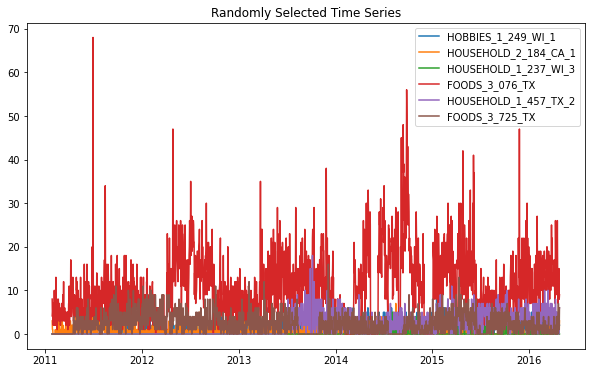

In [0]:
def plot_random_series(df, n_series):
    
    sample = df.sample(n_series, random_state=np.random.randint(100))
    page_labels = sample['id'].tolist()
    series_samples = sample.loc[:,data_start_date:data_end_date]
    
    plt.figure(figsize=(10,6))
    
    for i in range(series_samples.shape[0]):
        pd.Series(series_samples.iloc[i]).astype(np.float64).plot(linewidth=1.5)
    
    plt.title('Randomly Selected Time Series')
    plt.legend(page_labels)

# plot a times series for n random products
plot_random_series(df, 6)

In [0]:
# initialization of interval variables

pred_steps = 28
pred_length = timedelta(pred_steps)

first_day = pd.to_datetime(data_start_date) 
last_day = pd.to_datetime(data_end_date)

test_pred_start = last_day - pred_length + timedelta(1)
test_pred_end = last_day

val_pred_start = test_pred_start - pred_length
val_pred_end = test_pred_start - timedelta(days=1)

train_pred_start = val_pred_start - pred_length
train_pred_end = val_pred_start - timedelta(days=1)

enc_length = train_pred_start - first_day

train_enc_start = first_day
train_enc_end = train_enc_start + enc_length - timedelta(1)

val_enc_start = train_enc_start + pred_length
val_enc_end = val_enc_start + enc_length - timedelta(1)

test_enc_start = val_enc_start + pred_length
test_enc_end = test_enc_start + enc_length - timedelta(1)

print('Train encoding:', train_enc_start, '-', train_enc_end)
print('Train prediction:', train_pred_start, '-', train_pred_end, '\n')
print('Val encoding:', val_enc_start, '-', val_enc_end)
print('Val prediction:', val_pred_start, '-', val_pred_end, '\n')
print('Test encoding:', test_enc_start, '-', test_enc_end)
print('Test prediction:', test_pred_start, '-', test_pred_end)

print('\nEncoding interval:', enc_length.days)
print('Prediction interval:', pred_length.days)

RNN-LSTM Approach

In [0]:
n_samples = None #Set this to a finite number to train on a reduced number of samples
batch_size = 64
epochs = 25
learning_rate = 1e-3

series_array = df[df.columns[1:]].values

encoder_input_data, encode_series_mean, decoder_input_data, decoder_target_data = m5_helpers.get_all_data(date_to_index, series_array, train_enc_start, train_enc_end, train_pred_start, train_pred_end, n_samples=n_samples)

# a way of saving progress of our model while training
callbacks = m5_helpers.make_callbacks('lstm', 'lstm_run_1')

# initialize the model and other states that will be useful when running the model
model, dec_model, encoder_inputs, encoder_states = m5_models.create_enc_dec(learning_rate=learning_rate, hidden_size = 32, dropout = 0)

history = model.fit([encoder_input_data, decoder_input_data], decoder_target_data,
                     batch_size=batch_size,
                     epochs=epochs,
                     validation_split=0.2,
                     callbacks=callbacks)

In [0]:
# history = model.fit([encoder_input_data, decoder_input_data], decoder_target_data,
#                      batch_size=batch_size,
#                      epochs=epochs,
#                      validation_split=0.2,
#                      callbacks=callbacks)

In [0]:
m5_helpers.make_training_plot(history)

In [0]:
encoder_model = Model(encoder_inputs, encoder_states)

encoder_input_data, encode_series_mean, decoder_input_data, decoder_target_data = m5_helpers.get_all_data(date_to_index, series_array, val_enc_start, val_enc_end, val_pred_start, val_pred_end, shuffle=False)

m5_helpers.predict_and_plot(encoder_model, encoder_input_data, decoder_target_data, encode_series_mean, sample_ind=0, enc_tail_len=250, lstm=True, dec_model=dec_model)

Wavenet Approach

In [0]:
n_samples = 42840 #Set this to a finite number to train on a reduced number of samples
batch_size = 256
epochs = 5
learning_rate = 3e-4

series_array = df[df.columns[1:]].values
# weights = e.weights[:first_n_samples][0]

encoder_input_data, encode_series_mean, decoder_input_data, decoder_target_data = m5_helpers.get_all_data(date_to_index, series_array, train_enc_start, train_enc_end, train_pred_start, train_pred_end, n_samples=n_samples)

# we append a lagged history of the target series to the input data, so that we can train with teacher forcing
lagged_target_history = decoder_target_data[:,:-1,:1]
encoder_input_data = np.concatenate([encoder_input_data, lagged_target_history], axis=1)

callbacks = m5_helpers.make_callbacks('wavenet_model', 'wavenet_1')
score_cb = m5_helpers.score_callback(e=e, ids=[x+'_validation' for x in df.id], val_encoder_input=encoder_input_data, val_encode_series_mean=encode_series_mean)
callbacks.insert(0, score_cb)

# Create a simple wavenet model
model = m5_models.create_simple_wave(learning_rate=learning_rate)

# Create a larger more complex wavenet model
# model = Model_Functions.create_full_wave(learning_rate=learning_rate)

print(model.summary())
history = model.fit(encoder_input_data, decoder_target_data,
                    batch_size=batch_size,
                    epochs=epochs,
                    validation_split=0.2,
                    callbacks=callbacks)

In [0]:
n_samples = 42840 #Set this to a finite number to train on a reduced number of samples
batch_size = 256
epochs = 5
learning_rate = 3e-4

series_array = df[df.columns[1:]].values
# weights = e.weights[:first_n_samples][0]

encoder_input_data, encode_series_mean, decoder_input_data, decoder_target_data = m5_helpers.get_all_data(date_to_index, series_array, train_enc_start, train_enc_end, train_pred_start, train_pred_end, n_samples=n_samples)

# we append a lagged history of the target series to the input data, so that we can train with teacher forcing
lagged_target_history = decoder_target_data[:,:-1,:1]
encoder_input_data = np.concatenate([encoder_input_data, lagged_target_history], axis=1)

callbacks = m5_helpers.make_callbacks('wavenet_model', 'wavenet_1')
score_cb = m5_helpers.score_callback(e=e, ids=[x+'_validation' for x in df.id], val_encoder_input=encoder_input_data, val_encode_series_mean=encode_series_mean)
callbacks.insert(0, score_cb)

# Create a simple wavenet model
model = m5_models.create_simple_wave(learning_rate=learning_rate)

# Create a larger more complex wavenet model
# model = Model_Functions.create_full_wave(learning_rate=learning_rate)

print(model.summary())
tf.keras.utils.plot_model(model,show_shapes=True)

In [0]:
m5_helpers.make_training_plot(history)

In [0]:
encoder_input_data, encode_series_mean, decoder_input_data, decoder_target_data = m5_helpers.get_all_data(date_to_index, series_array, val_enc_start, val_enc_end, val_pred_start, val_pred_end, shuffle=False)

m5_helpers.predict_and_plot(model, encoder_input_data, decoder_target_data, encode_series_mean, 35000, enc_tail_len=250, lstm=False, dec_model=None)

In [0]:
batch_size = 1024
input_steps = 28*4
pred_steps=28

val_frac=0.1
series_array = sklearn.utils.shuffle(df[df.columns[1:]].values, random_state=42) # shuffle once up front so don't have to waste time later
weights = sklearn.utils.shuffle(e.weights[0], random_state=42)
train_samples = int((1-val_frac)*series_array.shape[0])-1
val_samples = int(val_frac**series_array.shape[0])

first_valid_day = first_day + timedelta(days=input_steps)
valid_train_end_days = [first_valid_day + timedelta(days=x) for x in range((train_enc_end-first_valid_day).days + 1)]

def data_generator():
    random_start_id = np.random.choice(train_samples-batch_size-val_samples, 1)[0]
    random_train_enc_end_day = np.random.choice(valid_train_end_days, 1)[0]
    random_train_enc_start_day = random_train_enc_end_day - timedelta(days=input_steps-1)
    
    random_train_pred_start_day = random_train_enc_end_day + timedelta(days=1)
    random_train_pred_end_day = random_train_pred_start_day + timedelta(days=pred_steps) - timedelta(1)

    encoder_input_data, encode_series_mean, decoder_input_data, decoder_target_data = m5_helpers.get_all_data(date_to_index, series_array, 
                                                                                                                    random_train_enc_start_day, random_train_enc_end_day, 
                                                                                                                    random_train_pred_start_day, random_train_pred_end_day, 
                                                                                                                    shuffle=True, n_samples=train_samples)
    yield (encoder_input_data[random_start_id:random_start_id+batch_size,:,:], 
    decoder_target_data[random_start_id:random_start_id+batch_size,:,:],
    weights[random_start_id:random_start_id+batch_size])

series_array = df[df.columns[1:]].values
weights = e.weights[0]

encoder_input_data, encode_series_mean, decoder_input_data, decoder_target_data = m5_helpers.get_all_data(date_to_index, series_array, val_pred_start - timedelta(days=input_steps), val_pred_start - timedelta(days=1), val_pred_start, val_pred_end, shuffle=False)
validation_data = (encoder_input_data, decoder_target_data, weights)
validation_dataset = tf.data.Dataset.from_tensor_slices(validation_data).batch(batch_size)

N-BEATS approach

In [0]:
import nbeats_keras.model as nbeats
# import nbeats_pytorch.model as nbeats
from nbeats_keras.model import NBeatsNet

In [0]:
# !make install-keras
# !make install-pytorch
!pip install --upgrade tensorflow

In [0]:
# from tensorflow.keras.models import Sequential
# from tensorflow.keras.layers import Input, Conv2D, MaxPool2D, Dense

In [0]:
epochs = 5
learning_rate=3e-4

callbacks = m5_helpers.make_callbacks('nbeats_model', 'nbeats_run_1')

# val_encoder_input = pd.concat([df.id, pd.DataFrame(encoder_input_data.reshape(-1,28))], axis=1, ignore_index=True)

score_cb = m5_helpers.score_callback(e=e, ids=[x+'_validation' for x in df.id], val_encoder_input=encoder_input_data, val_encode_series_mean=encode_series_mean)
callbacks.insert(0, score_cb)

shapes = ((batch_size, input_steps, 1),(batch_size, pred_steps, 1),(batch_size,))
dataset = tf.data.Dataset.from_generator(data_generator, (tf.float32, tf.float32, tf.float32), output_shapes=shapes).repeat()

model = NBeatsNet(backcast_length=input_steps, forecast_length=pred_steps,
                  stack_types=(NBeatsNet.GENERIC_BLOCK, NBeatsNet.GENERIC_BLOCK), nb_blocks_per_stack=2,
                  thetas_dim=(4, 4), share_weights_in_stack=False, hidden_layer_units=8)

model.compile(Adam(learning_rate=learning_rate), loss='mse', metrics=[tf.keras.metrics.RootMeanSquaredError()])
history = model.fit(dataset, steps_per_epoch=200, validation_data=validation_dataset, callbacks=callbacks, epochs=epochs)

In [0]:
m5_helpers.make_training_plot(history)

In [0]:
encoder_input_data, encode_series_mean, decoder_input_data, decoder_target_data = m5_helpers.get_all_data(date_to_index, series_array, val_pred_start - timedelta(days=input_steps), val_pred_start - timedelta(days=1), val_pred_start, val_pred_end, shuffle=False)

m5_helpers.predict_and_plot(model, encoder_input_data, decoder_target_data, encode_series_mean, sample_ind=1000, enc_tail_len=input_steps, lstm=False, dec_model=None, nbeats=True)

In [0]:
predict_batch_size = 1024
series_array = pd.read_csv(f'{path}/sales_train_validation.csv').iloc[:,6:].values
batches = series_array.shape[0]//predict_batch_size+1
preds = []

encoder_input_data, encode_series_mean, decoder_input_data, decoder_target_data = m5_helpers.get_all_data(date_to_index, series_array, val_pred_start - timedelta(days=input_steps), val_pred_start - timedelta(days=1), val_pred_start, val_pred_end, shuffle=False)
predictions = model.predict(encoder_input_data)

In [0]:
predictions = m5_helpers.untransform_series_decode(predictions, encode_series_mean)
predictions = pd.DataFrame(predictions.reshape(-1,28))
predictions['id']=train_df.id
predictions = predictions[['id']+list(predictions.columns[:-1])]
predictions.columns = ['id'] + ['d_' + str(x+1886) for x in np.arange(28)]

# Score on val set
print('Score: ' + str(e.score(predictions.iloc[:,1:])))

In [0]:
# Look at which time series are contributing to this score
print(e.contributors)

In [0]:
# For submission
# submitte_predictions = predictions.iloc[:,1:]
# submitte_predictions.columns = ['F'+str(x+1) for x in np.arange(28)]

# Make submissions file
sample_submission = pd.DataFrame(pd.read_csv(f'{path}/sample_submission.csv').id)
sample_submission = sample_submission.merge(predictions, on='id', how='left')
sample_submission.fillna(0, inplace=True)
sample_submission.to_csv('submission.csv', index=False)
sample_submission.head()